# 0. Executive summary

Prepared by [RJ Ellis](http://robjellis.net/index.html), 20 July 2018.

### Background:
- Company XYZ sells a software for 39 dollars. 
- Since revenue has been flat for some time, the VP of Product has decided to run a test increasing the price. She hopes that this would increase revenue. 
- In the experiment, 66% of the users have seen the old price (\$39 dollars), while a random sample of 33% of users a higher price (\$59 dollars).

### Key findings:
#### 1. Increasing the price to \$59 dollars results in significantly lower purchase rates across nearly all market segments.
- Overall conversion drops from 1.99% (at \$39) to 1.56% (at \$59).
- This pattern generally holds when segmenting by Device, Operating System, and Referral Source.
- The largest geographic marked (NYC) also sees a lower purchase rate at the higher price point.

#### 2. However, revenue is increased by 18.25% when the price is raised to $59.
- For every 100,000 website visitors, expected revenue is ~\$78,000 at the **lower** price point.
- For every 100,000 website visitors, expected revenue is ~\$92,000 at the **higher** price point.

#### 3. The experiment could have been terminated after three weeks.
- The experiment was successfully designed; similar numbers of Control arm and Experimental arm subjects were present in each one-week window between March 2 2015 and May 31 2015.
- By taking the cumulative number of subjects (and conversions) across time, statistical significance is reached (with respect to lower conversion rates / higher revenue) by the end of the third week.

# 1. Data wrangling

In [2]:
import numpy as np
import pandas as pd
pd.set_option('max_rows', 500)

import seaborn as sns

import scipy.stats
import statsmodels.api as sm
import time
import datetime

%matplotlib inline

from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt

In [3]:
# plotting params
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 17})

### Read and merge the datasets

In [4]:
file_user = r"C:\Users\robje\_PY\insight\data_challenge_3\user_table.csv"
file_res  = r"C:\Users\robje\_PY\insight\data_challenge_3\test_results.csv"

In [5]:
df_u = pd.read_csv(file_user)
print('df_u shape:', df_u.shape)

df_r = pd.read_csv(file_res)
print('df_r shape:', df_r.shape)

df_u shape: (275616, 5)
df_r shape: (316800, 8)


Are all the `user_id` values unique in each file?

In [6]:
print(len(df_r['user_id'].unique()) == len(df_r['user_id']))
print(len(df_u['user_id'].unique()) == len(df_u['user_id']))

True
True


### Datetime conversions
There were issues with using `pd.to_datetime` directly on `timestamp`, but for a first-pass analysis we don't worry about hours, minutes, and seconds.

In [7]:
dates = [i[0:10] for i in df_r['timestamp']]

df_r['date'] = pd.to_datetime(dates)

### Join user data with results data

In [8]:
df = df_r.merge(df_u, how='left', on='user_id') # left join

# rename operative_system
df.rename(index=str, 
          columns={"operative_system": "os"},
          inplace=True)

# add a boolean column to indicate whether we have user information
df['user_data'] = pd.isnull(df['city']) == False

In [9]:
df.head()

,user_id,timestamp,source,device,os,test,price,converted,date,city,country,lat,long,user_data
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,2015-05-08,Buffalo,USA,42.89,-78.86,True
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,2015-05-10,Lakeville,USA,44.68,-93.24,True
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,2015-04-04,Parma,USA,41.38,-81.73,True
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,2015-05-07,Fayetteville,USA,35.07,-78.90,True
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,2015-05-24,Fishers,USA,39.95,-86.02,True


Eliminate cases where `test` does not match `price`

In [10]:
df.groupby(('test','price')).count()['user_id']

test  price
0     39       202517
      59          210
1     39          155
      59       113918
Name: user_id, dtype: int64

In [11]:
keep_cont = ((df['test']==0) & (df['price']==39))
keep_exp  = ((df['test']==1) & (df['price']==59))

keep = keep_cont | keep_exp

print('There are {} valid cases.'.format(sum(keep)))

# exclude them from the dataframe
df = df[keep]

There are 316435 valid cases.


# 2. High-level insights

## Overall effect on *Conversion Rate*
- In the chart below,`count` is the total number of subjects in the study arm, `sum` is the number of conversions, and `mean` is the conversion rate (0 to 1 scale).
- We find that the test arm had a LOWER conversion rate (~1.56%) than the control arm (~1.99%).

In [12]:
xx = df.groupby(['test'])['converted'].agg(['count','sum','mean']).reset_index()
xx

,test,count,sum,mean
0,0,202517,4030,0.019900
1,1,113918,1772,0.015555


### Is this a significant difference? We can use the $Z$-test for two binomial proportions to answer this.
- Online examples: [here](http://vassarstats.net/propdiff_ind.html) and [here](http://www.socscistatistics.com/tests/ztest/Default2.aspx).
- Formula (e.g., per [here](https://www.itl.nist.gov/div898/software/dataplot/refman1/auxillar/binotest.htm):
<img src='http://www.statisticshowto.com/wp-content/uploads/2014/02/two-proprtion-z-test.png'>
- The $Z$-value indicates whether the difference in observed conversion rates is significantly different between test and control arms.
- If more time were available to perform this analysis, it would be preferable to compute confidence intervals on the 2-sample test; see e.g., [here](http://vassarstats.net/prop2_ind.html) and [here](https://sigmazone.com/binomial-confidence-intervals/).

### Here is an example calculator:
- This shows how the same increase in conversion (e.g., 5% to 10%) becomes significant as $N$ increases:

In [13]:
nconv = [5,   10]
nobs  = [100, 100]
zval, pval = sm.stats.proportions_ztest(nconv, nobs) # 2-tailed by default
print('Z-value:',zval)
print('P-value:',pval)

Z-value: -1.3423121104280487
P-value: 0.1794948183730305


In [14]:
nconv = [50,   100]
nobs  = [1000, 1000]
zval, pval = sm.stats.proportions_ztest(nconv, nobs) # 2-tailed by default
print('Z-value:',zval)
print('P-value:',pval)

Z-value: -4.244763599780089
P-value: 2.188239933614016e-05


### And now the actual result from the current experiment. 
- Note that $Z$ has a negative value, and p-value is significant (< .05).
- This indicates that conversions are **significantly reduced** in the Experimental arm relative to the Control arm.

In [15]:
nconv = [1772,   4030]
nobs  = [113918, 202517]
zval, pval = sm.stats.proportions_ztest(nconv, nobs) # 2-tailed by default
print('Z-value:',zval)
print('P-value:',pval)

Z-value: -8.74375299250435
P-value: 2.2549214716059568e-18


## Overall effect on *Revenue*
- Even though conversion rate is **decreased**, we find that overall revenue is **increased** by a wide margin.

In [16]:
per = 100000

## xx is dataframe from above
rev_cont = xx.iloc[0]['mean'] * per * 39
rev_exp  = xx.iloc[1]['mean'] * per * 59

print('Per {} website visitors:'.format(per))
print('   Revenue when price is $39: ${}'.format(np.round(rev_cont,2)))
print('   Revenue when price is $59: ${}'.format(np.round(rev_exp,2)))

# percentage increase in revenue
prc_inc = 100 * (rev_exp - rev_cont) / rev_cont
print('\nIncrease in revenue when moving from $39 to $59 price point: {}%'.format(np.round(prc_inc,2)))

Per 100000 website visitors:
   Revenue when price is $39: $77608.3
   Revenue when price is $59: $91774.79

Increase in revenue when moving from $39 to $59 price point: 18.25%


# 3. Segmentation analyses

First, a bit of code to help us run $Z$-tests more easily:

In [17]:
def bino_z(dfin,group_by,thr):
    '''
    dfin is the main df
    group_by is the variable (or variable list) used to do the groupby operation
    thr is the minimum number of conversions we need to see in *both* control an experimental
    
    Note: code is written so that same number of levels occur for both test == 0 and test == 1; 
    this makes life much easier in computing the z-test
    '''

    #group_by.insert(0,'test') # need this in first position

    xx = dfin.groupby(group_by)['converted'].agg(['count','sum','mean']) # standard groupby

    xx = xx.unstack(fill_value=0).stack() # make sure we count zeros!

    xx.reset_index(inplace=True)
    
    # output this
    yy = xx

    # now split this in two
    y0 = xx[xx['test'] == 0]
    y1 = xx[xx['test'] == 1]

    # separate control and experimental
    y0_nobs = y0['count']
    y0_nconv = y0['sum']

    y1_nobs = y1['count']
    y1_nconv = y1['sum']

    # loop
    nitem = y0.shape[0]

    zval = np.zeros(nitem) + np.nan
    pval = np.zeros(nitem) + np.nan
    sig  = np.zeros(nitem) + np.nan
    
    for i in np.arange(nitem):
        #print(i)
        nobs  = [y1_nobs.iloc[i], y0_nobs.iloc[i]]  # experimental before control; sign is negative if Conv(exp) < Conv(cont)
        nconv = [y1_nconv.iloc[i], y0_nconv.iloc[i]]

        if min(nconv) >= thr: # useful threshold; let's ignore very low conversion counts
            
            z, p = sm.stats.proportions_ztest(nconv, nobs) # 2-tailed by default

            zval[i] = z
            pval[i] = p
            if p < .05:
                sig[i] = 1
            else:
                sig[i] = 0

    # make output df
    zz = y0.copy()

    zz.rename(index=str, 
              columns={'count': 'nobs_0', 'sum': 'nconv_0', 'mean': 'rate_0'},
              inplace=True)

    zz['nobs_1'] = y1['count'].values
    zz['nconv_1'] = y1['sum'].values
    zz['rate_1'] = y1['mean'].values

    #zz.drop(columns = 'test', inplace=True)
    
    # difference
    np.seterr(all='ignore')
    zz['diff'] = zz['rate_1'] - zz['rate_0']

    # add z and p
    zz['zval'] = zval
    zz['pval'] = pval
    #zz['sig'] = pval < .05
    zz['sig'] = sig
    
    # plot
    if ((len(group_by) == 2) & (nitem <= 12)):
        figsize(14,6)
        feature = group_by[1]
        
        # old version - line plot
        #plt.plot(zz[feature],zz['rate_0'],marker='o',ms=10,label='Control')
        #plt.plot(zz[feature],zz['rate_1'],marker='o',ms=10,label='Experiment')
        #plt.ylabel('Conversion rate')
        #plt.xlabel(feature)
        
        # new version - bar chart (easy to add CIs later)
        ind = np.arange(nitem)  # the x locations for the groups
        width = 0.3       # the width of the bars    
        plt.bar(ind, zz['rate_0'], width, label='Control')
        plt.bar(ind+width, zz['rate_1'], width, label='Experiment')

        locs = ind + width / 2
        plt.xticks(locs, zz[feature])
        
        # add in significance
        keep = zz['sig'] == True
        aa = zz[keep]
        plt.plot(locs[keep],zz[keep]['sig']/20,'*',color = '#74C127', ms=20,label='$P$ < .05')
        
        # labels, etc.
        plt.ylim((-0.002,.053))  
        plt.legend(loc=5, bbox_to_anchor=(1.2, 0.5));       
        plt.ylabel('Conversion rate')
        plt.xlabel(feature)
        
        if nitem > 7:
            plt.xticks(rotation=90)
    
    return zz

### Segmentation by device:

,test,device,nobs_0,nconv_0,rate_0,nobs_1,nconv_1,rate_1,diff,zval,pval,sig
0,0,mobile,120369,2392,0.019872,65898,1064,0.016146,-0.003726,-5.698012,1.212128e-08,1.0
1,0,web,82148,1638,0.019940,48020,708,0.014744,-0.005196,-6.798989,1.053559e-11,1.0


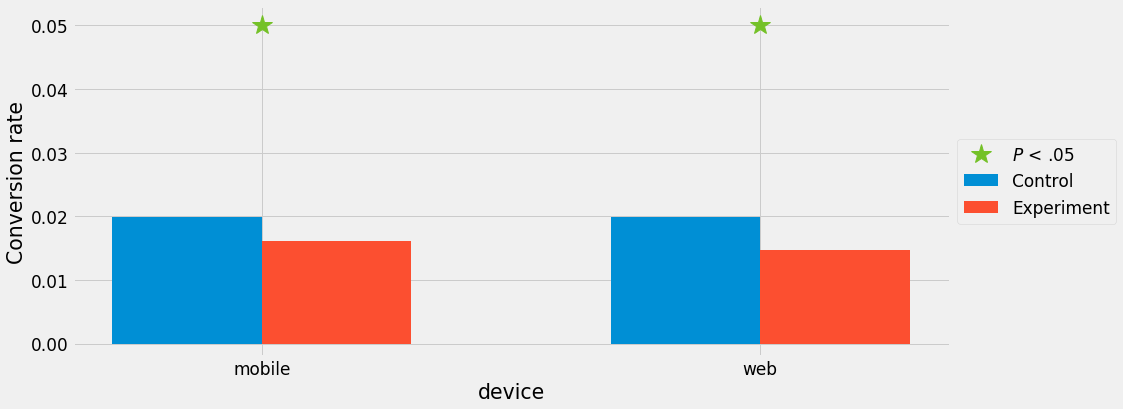

In [18]:
bino_z(df,['test','device'],10)

### Segmentation by operating system:
- Linux and "Other" were the only OS that did not show a significant decrease in conversion
- **Android and Windows have larger $Z$-values than iOS and Mac**

,test,os,nobs_0,nconv_0,rate_0,nobs_1,nconv_1,rate_1,diff,zval,pval,sig
0,0,android,48177,787,0.016336,26693,330,0.012363,-0.003973,-4.294901,1.747710e-05,1.0
1,0,iOS,61793,1458,0.023595,33560,671,0.019994,-0.003601,-3.594206,3.253825e-04,1.0
2,0,linux,2204,34,0.015426,1926,0,0.000000,-0.015426,NaN,NaN,NaN
3,0,mac,16345,416,0.025451,8710,185,0.021240,-0.004211,-2.074665,3.801758e-02,1.0
4,0,other,10481,147,0.014025,5696,63,0.011060,-0.002965,-1.591244,1.115548e-01,0.0
5,0,windows,63517,1188,0.018704,37333,523,0.014009,-0.004695,-5.574177,2.487028e-08,1.0


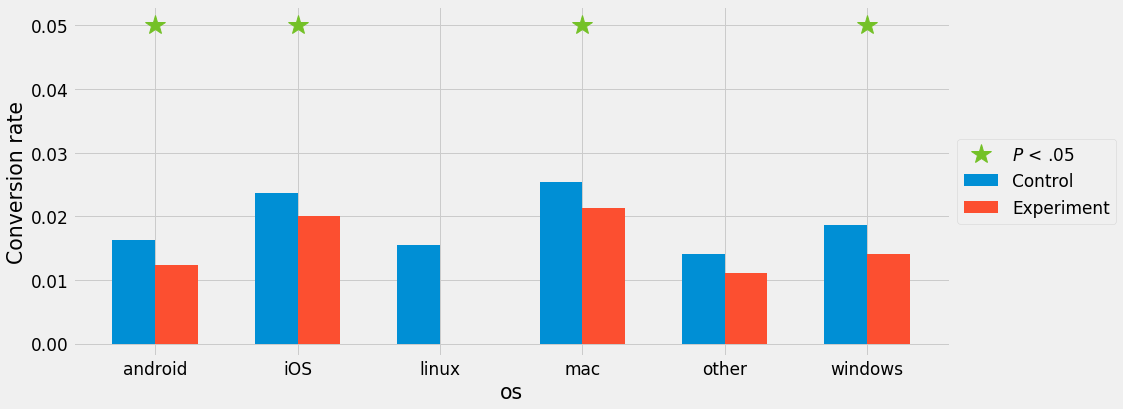

In [19]:
bino_z(df,['test','os'],10)

### Segmentation by referral source:
- Interesting: `friend_referral` has a much higher conversion rate than all other sources.

,test,source,nobs_0,nconv_0,rate_0,nobs_1,nconv_1,rate_1,diff,zval,pval,sig
0,0,ads-bing,14584,195,0.013371,8247,79,0.009579,-0.003792,-2.527276,1.149512e-02,1.0
1,0,ads-google,37845,854,0.022566,21497,422,0.019631,-0.002935,-2.369236,1.782488e-02,1.0
2,0,ads-yahoo,4812,81,0.016833,2759,31,0.011236,-0.005597,-1.941415,5.220796e-02,0.0
3,0,ads_facebook,34074,806,0.023654,19281,325,0.016856,-0.006798,-5.237282,1.629585e-07,1.0
4,0,ads_other,19256,297,0.015424,10570,131,0.012394,-0.003030,-2.104787,3.530985e-02,1.0
5,0,direct_traffic,38712,523,0.013510,21560,218,0.010111,-0.003399,-3.629425,2.840533e-04,1.0
6,0,friend_referral,13121,547,0.041689,7557,253,0.033479,-0.008210,-2.947979,3.198589e-03,1.0
7,0,seo-bing,1329,40,0.030098,815,11,0.013497,-0.016601,-2.448585,1.434185e-02,1.0
8,0,seo-google,15088,264,0.017497,8060,129,0.016005,-0.001492,-0.837311,4.024180e-01,0.0
9,0,seo-other,5879,103,0.017520,3365,42,0.012481,-0.005039,-1.875857,6.067486e-02,0.0


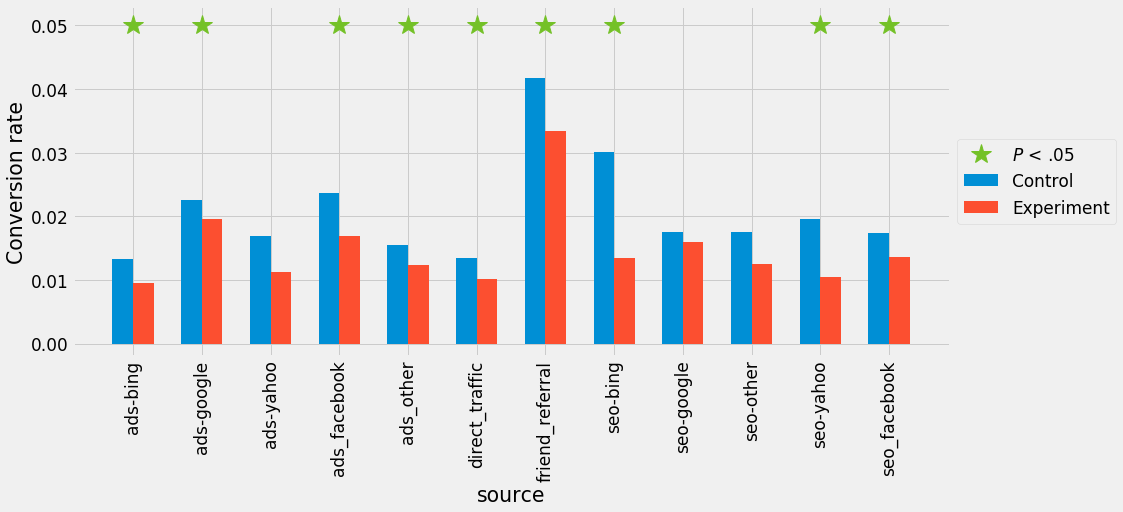

In [20]:
bino_z(df,['test','source'],10)

### When we look at conversion rates by City, all but NYC are non-significant w.r.t. conversion rate.
- We exclude cities that have a very low number of converstions period (< 10).
- Thus, we **don't need to worry** about segmenting by City in this first-pass analysis.

In [21]:
print('There are {} unique cities in the dataset.'.format(len((df['city'].unique()))))

There are 924 unique cities in the dataset.


In [22]:
xx = bino_z(df,['test','city'],10)
xx[xx['sig']==True]

,test,city,nobs_0,nconv_0,rate_0,nobs_1,nconv_1,rate_1,diff,zval,pval,sig
552,0,New York,16559,307,0.01854,9159,136,0.014849,-0.003691,-2.178484,0.02937,1.0


### Does anything jump out when we factorially combine Device, Operating system, and Referral source?
- Answer: not really. Out of the 84 possible combinations, only 7 are statistically significant.

In [23]:
xx = bino_z(df,['test','device','os','source'],10)

print('There are {} levels of device x operating system x referral source.'.format(xx.shape[0]))
xx[xx['sig']==True]

There are 84 levels of device x operating system x referral source.


,test,device,os,source,nobs_0,nconv_0,rate_0,nobs_1,nconv_1,rate_1,diff,zval,pval,sig
0,0,mobile,android,ads-bing,3457,45,0.013017,1917,12,0.006260,-0.006757,-2.316387,0.020537,1.0
1,0,mobile,android,ads-google,8785,170,0.019351,5102,70,0.013720,-0.005631,-2.454771,0.014097,1.0
15,0,mobile,iOS,ads_facebook,10570,295,0.027909,5891,116,0.019691,-0.008218,-3.239473,0.001198,1.0
51,0,web,mac,ads_facebook,2724,89,0.032673,1514,30,0.019815,-0.012857,-2.427915,0.015186,1.0
75,0,web,windows,ads_facebook,10555,227,0.021506,6240,103,0.016506,-0.005000,-2.256016,0.024070,1.0
77,0,web,windows,direct_traffic,11988,155,0.012930,7146,63,0.008816,-0.004113,-2.593425,0.009503,1.0
78,0,web,windows,friend_referral,4054,165,0.040701,2479,70,0.028237,-0.012463,-2.625040,0.008664,1.0


# 4. Effects over time

When did the study start and stop?

In [24]:
print('First day of data collection:',min(df['date']))
print('Last day of data collection:',max(df['date']))

First day of data collection: 2015-03-02 00:00:00
Last day of data collection: 2015-05-31 00:00:00


- March 2 2015 was a Monday
- May 31 2015 was a Friday

### We see similar counts per week in both Control and Experimental

In [25]:
grp = pd.Grouper(key='date', freq='W-Sun') # tally cases up to each date
xx = bino_z(df,['test', grp],0)
xx

,test,date,nobs_0,nconv_0,rate_0,nobs_1,nconv_1,rate_1,diff,zval,pval,sig
0,0,2015-03-08,15638,331,0.021166,9036,157,0.017375,-0.003791,-2.060684,0.039333,1.0
1,0,2015-03-15,15792,282,0.017857,8465,134,0.015830,-0.002027,-1.159178,0.246384,0.0
2,0,2015-03-22,15727,314,0.019966,8727,141,0.016157,-0.003809,-2.111683,0.034714,1.0
3,0,2015-03-29,15329,297,0.019375,9104,142,0.015598,-0.003778,-2.149228,0.031616,1.0
4,0,2015-04-05,15641,321,0.020523,8377,119,0.014206,-0.006317,-3.479405,0.000503,1.0
5,0,2015-04-12,15838,313,0.019763,9022,134,0.014853,-0.004910,-2.801370,0.005089,1.0
6,0,2015-04-19,15524,327,0.021064,8664,135,0.015582,-0.005482,-2.986770,0.002819,1.0
7,0,2015-04-26,15529,322,0.020735,8724,144,0.016506,-0.004229,-2.302548,0.021304,1.0
8,0,2015-05-03,15612,308,0.019728,8740,113,0.012929,-0.006799,-3.904796,0.000094,1.0
9,0,2015-05-10,15740,295,0.018742,8788,132,0.015020,-0.003722,-2.136849,0.032610,1.0


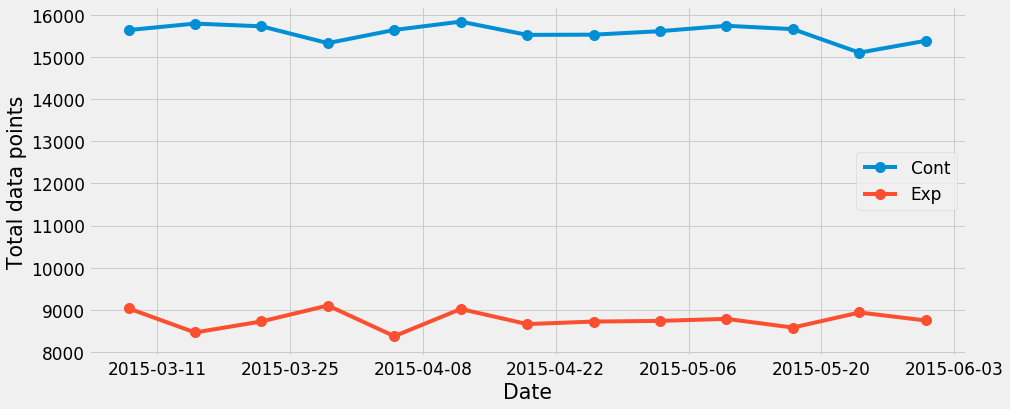

In [26]:
# make a plot of amount of data in Control and Experimental arms by week
plt.plot(xx['date'],xx['nobs_0'],label='Cont',marker='o',ms=10)
plt.plot(xx['date'],xx['nobs_1'],label='Exp',marker='o',ms=10)
plt.legend()
plt.ylim((7900,16200))
plt.xlabel('Date')
plt.ylabel('Total data points');

### How does the Z-test differ by week?
- We see that individual weeks are sometimes significant (i.e., Z < -1.96), and sometimes not:

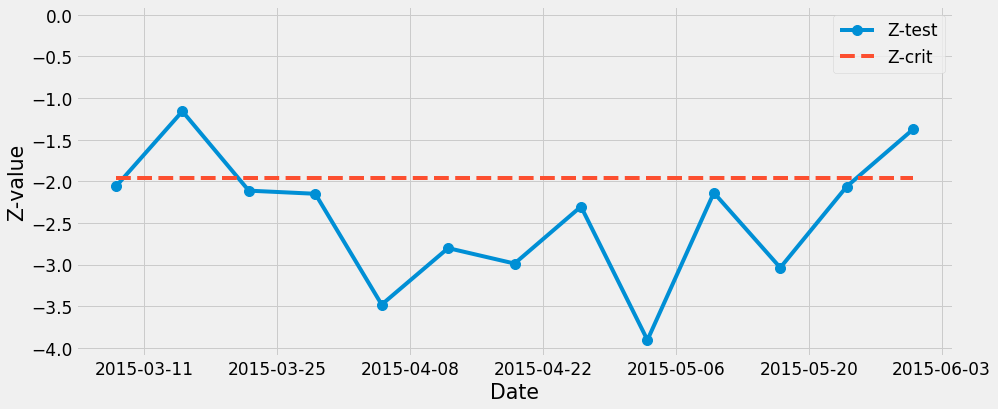

In [27]:
plt.plot(xx['date'],xx['zval'],marker='o',ms=10,label='Z-test')
plt.plot([xx.iloc[0]['date'], xx.iloc[-1]['date']],[-1.96, -1.96],ls='dashed',label='Z-crit')
plt.ylim((-4.1,0.1))
plt.legend()
plt.xlabel('Date')
plt.ylabel('Z-value');

### Compute the *cumulative* tallies for observations and conversions to determine an optimal stopping point:

In [28]:
# code
nobs_0_cs = np.cumsum(xx['nobs_0'])
nobs_1_cs = np.cumsum(xx['nobs_1'])

nconv_0_cs = np.cumsum(xx['nconv_0'])
nconv_1_cs = np.cumsum(xx['nconv_1'])

# new dataframe _cs to indicate cumulative sum
df_cs = pd.DataFrame()
df_cs['date'] = xx['date']

df_cs['nobs_0'] = nobs_0_cs
df_cs['nconv_0'] = nconv_0_cs
df_cs['rate_0'] = nconv_0_cs / nobs_0_cs

df_cs['nobs_1'] = nobs_1_cs
df_cs['nconv_1'] = nconv_1_cs
df_cs['rate_1'] = nconv_1_cs / nobs_1_cs

# z-score
zval = []
pval = []
for i in np.arange(df_cs.shape[0]):
    nobs  = [nobs_1_cs.iloc[i], nobs_0_cs.iloc[i]]  # experimental before control; sign is negative if Conv(exp) < Conv(cont)
    nconv = [nconv_1_cs.iloc[i], nconv_0_cs.iloc[i]]

    z, p = sm.stats.proportions_ztest(nconv, nobs) # 2-tailed by default
    
    zval.append(z)
    pval.append(p)

df_cs['diff'] = df_cs['rate_1'] - df_cs['rate_0']    
df_cs['zval'] = zval
df_cs['pval'] = pval

df_cs

,date,nobs_0,nconv_0,rate_0,nobs_1,nconv_1,rate_1,diff,zval,pval
0,2015-03-08,15638,331,0.021166,9036,157,0.017375,-0.003791,-2.060684,3.933324e-02
1,2015-03-15,31430,613,0.019504,17501,291,0.016628,-0.002876,-2.264453,2.354627e-02
2,2015-03-22,47157,927,0.019658,26228,432,0.016471,-0.003187,-3.068730,2.149709e-03
3,2015-03-29,62486,1224,0.019588,35332,574,0.016246,-0.003342,-3.738346,1.852348e-04
4,2015-04-05,78127,1545,0.019775,43709,693,0.015855,-0.003921,-4.888080,1.018242e-06
5,2015-04-12,93965,1858,0.019773,52731,827,0.015683,-0.004090,-5.607545,2.052167e-08
6,2015-04-19,109489,2185,0.019956,61395,962,0.015669,-0.004287,-6.324482,2.540836e-10
7,2015-04-26,125018,2507,0.020053,70119,1106,0.015773,-0.004280,-6.729220,1.705755e-11
8,2015-05-03,140630,2815,0.020017,78859,1219,0.015458,-0.004559,-7.629632,2.354252e-14
9,2015-05-10,156370,3110,0.019889,87647,1351,0.015414,-0.004475,-7.915747,2.457724e-15


Note: by May 31 2015, we see the same number of `nobs` and `nconv` for control and experimental arms as we do in **Section 2** (above).

### Even by the end of the *third week* of data collection, we have clear significance:
- That is, the higher price point significantly decreased conversions by the end of week 3.
- We could have thus terminated the experiment **by the end of week 3.**

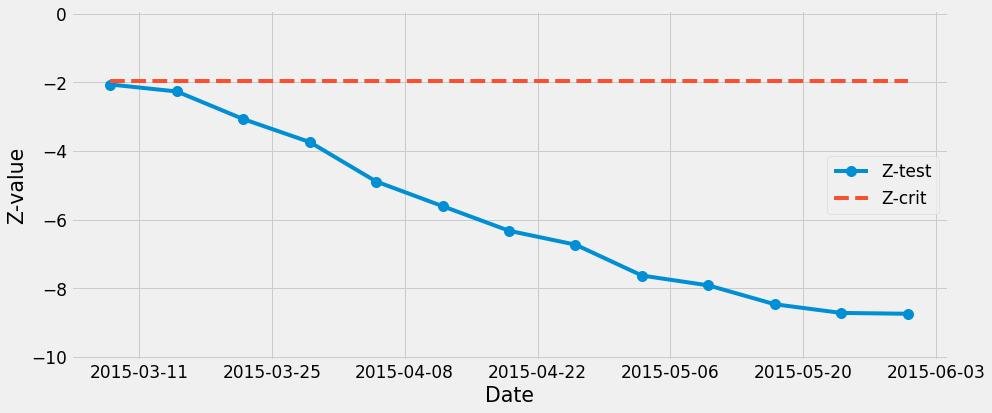

In [29]:
figsize(14,6)
plt.plot(df_cs['date'],df_cs['zval'],marker='o',ms=10,label='Z-test')
plt.ylim((-10.1,0.1))
plt.plot([df_cs.iloc[0]['date'], df_cs.iloc[-1]['date']],[-1.96, -1.96],ls='dashed',label='Z-crit')
plt.legend(loc=5)
plt.xlabel('Date')
plt.ylabel('Z-value');

# 5. Supplemental Content

### There is an easy function in statsmodels to compute the CI for a binomial proportion
- Wiki page for [Binomial Proportion Confidence Interval](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval) 
- In statsmodels: [here](http://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportion_confint.html)
- Normal CI:
<img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/fedc217f2ccb427f06d2a47f3cba501d193d3853'>
<br>
- Wilson Score CI:
<img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/c999019cc4f806d147bffb46158dc022b822f01a'>
<br>
- Jeffreys Bayesian CI uses  $Beta(x + 1/2, n – x + 1/2)$, and computes the posterior distribution as $Beta(s + 1/2, f + 1/2)$, where $s$ is number of successes and $f$ is number of failures (i.e., $n - s$).

In [30]:
# If we want to get a one-sample CI:
count = 1
nobs = 10
print('Normal CI:',sm.stats.proportion_confint(count, nobs, alpha=0.05, method='normal'))
print('Agresti-Coull CI:',sm.stats.proportion_confint(count, nobs, alpha=0.05, method='agresti_coull'))
print('Wilson Score CI:',sm.stats.proportion_confint(count, nobs, alpha=0.05, method='wilson'))
print('Jeffreys Bayesian CI:',sm.stats.proportion_confint(count, nobs, alpha=0.05, method='jeffreys'))

Normal CI: (-0.08593850969136851, 0.2859385096913685)
Agresti-Coull CI: (-0.00394149750452083, 0.4259677373948323)
Wilson Score CI: (0.017876213095072924, 0.40415002679523854)
Jeffreys Bayesian CI: (0.011011673763161142, 0.3813147710666164)


### Makin' some maps

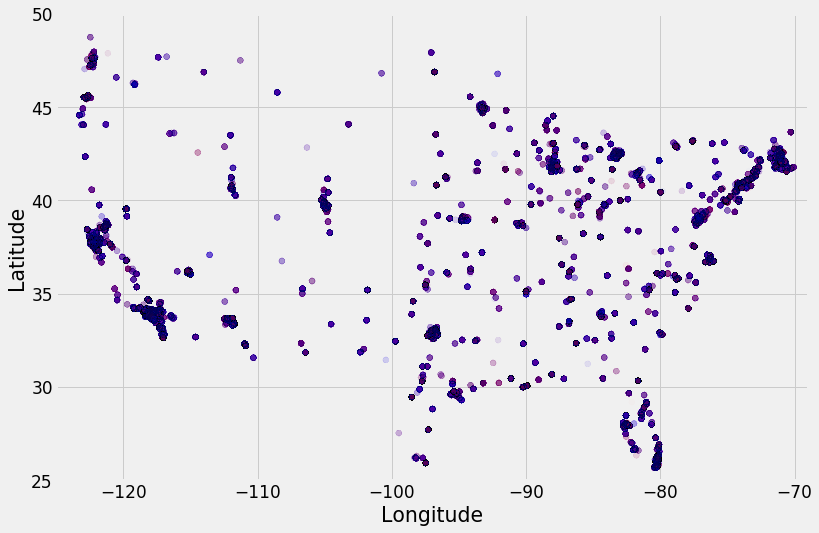

In [31]:
figsize(12,8)
color = df['test']
plt.scatter(df['long'],df['lat'],alpha=.01, c=color, cmap='bwr')
plt.xlim((-125,-69))
plt.ylim((25,50));
plt.xlabel('Longitude')
plt.ylabel('Latitude');